In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
import warnings
from datetime import datetime as dt
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_true = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/True.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake.csv")

In [ ]:
df_true['label'] = 1
df_fake['label'] = 0

# Concat dfs into one
df_all = pd.concat([df_true, df_fake]).reset_index(drop = True)
df_all.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df_all['original'] = df_all['title'] + ' / ' + df_all['text']
stop_words = stopwords.words('english')
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)

    return result
def listToString(s):
    # initialize an empty string
    str1 = " "
    # return string
    return (str1.join(s))

In [ ]:
df_all['processed_title'] = df_all['title'].apply(preprocess)
df_all['processed_text'] = df_all['text'].apply(preprocess)

# then from list back to string
df_all['processed_title'] = df_all['processed_title'].apply(listToString)
df_all['processed_text'] = df_all['processed_text'].apply(listToString)

In [ ]:
# creating new csv files
# getting a percentage (fraction) of all the news using frac argument with random choices, use frac=1 for whole dataset
sampled = df_all.sample(frac=1, random_state=7,replace=True)

# split train and test dataframes
position = int(sampled.shape[0] * 0.8)
train = sampled.iloc[:position]
test = sampled.iloc[position:]

# removing unwanted columns
test = test.drop(columns=['original', 'text', 'title'])
train = train.drop(columns=['original', 'text', 'title'])
# renaming columns
test = test.rename(columns={'processed_title': 'title', 'processed_text': 'text'})
train = train.rename(columns={'processed_title': 'title', 'processed_text': 'text'})

# saving...
test.to_csv(r"test.csv")
train.to_csv(r"train.csv")


In [ ]:
# printing the sizes of the dataframes
print("Number of news in TEST dataset is -> ", test.shape[0])
print("Number of news in TRAIN dataset is -> ", train.shape[0], "\n")

print("The number of the FAKE news in the TRAIN dataset is -> " + str(train[train.label == 0].shape[0]))
print("The number of the TRUE news in the TRAIN dataset is -> " + str(train[train.label == 1].shape[0]))
print("Analogy of real-fake news is -> " + str(round((train[train.label == 0].shape[0]/train.shape[0])*100,2)) + "% - " + str(round((train[train.label == 1].shape[0]/train.shape[0])*100,2)) +"%")
print("")
print("The number of the FAKE news in the TEST dataset is -> " + str(test[test.label == 0].shape[0]))
print("The number of the TRUE news in the TEST dataset is -> " + str(test[test.label == 1].shape[0]))
print("Analogy of real-fake news is -> " + str(round((test[test.label == 0].shape[0]/test.shape[0])*100,2)) + "% - " + str(round((test[test.label == 1].shape[0]/test.shape[0])*100,2)) +"%")


Number of news in TEST dataset is ->  8980
Number of news in TRAIN dataset is ->  35918 

The number of the FAKE news in the TRAIN dataset is -> 18797
The number of the TRUE news in the TRAIN dataset is -> 17121
Analogy of real-fake news is -> 52.33% - 47.67%

The number of the FAKE news in the TEST dataset is -> 4624
The number of the TRUE news in the TEST dataset is -> 4356
Analogy of real-fake news is -> 51.49% - 48.51%


In [ ]:
def document_vector(doc, w2v):
  # Create document vectors by averaging word vectors
    doc = doc.split(' ')
    doc = [word for word in doc if word in w2v.wv.key_to_index ]
    return np.mean(w2v.wv[doc], axis=0)
def enable_warnings():
    warnings.simplefilter('always')

In [ ]:
start = dt.now()
# process stuff
# COUNT VECTORIZER
CountVec = CountVectorizer(
                        ngram_range=(1,2), # (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
                        lowercase=True
                        )
# Initializing some parameters one time to be used by BOW implementation models
vec_train = CountVec.fit(train.text)
X_vec_train = vec_train.transform(train.text)
X_vec_test = vec_train.transform(test.text)
running_secs = (dt.now() - start).seconds
print('time: ' ,running_secs)
# start = dt.now()

# # TF-IDF VECTORIZER
# tf_idf_vec = TfidfVectorizer(
#                       use_idf=True,
#                       ngram_range=(1,2), # (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
#                       smooth_idf=True, # Prevents divide-by-zero errors
#                       lowercase=True # Convert everything to lower case
#                       )
# # Initializing some parameters one time to be used by TF-IDF implementation models
# vec_train_tf = tf_idf_vec.fit(train.text)
# X_vec_train_tf = vec_train_tf.transform(train.text)
# X_vec_test_tf = vec_train_tf.transform(test.text)

# Word2Vec VECTORIZER
# running_secs = (dt.now() - start).seconds
# print('time: ' ,running_secs)
# start = dt.now()
# creating a list of words from the titles
X = [x.split(' ') for x in train.text]

EMBEDDING_DIM = 100
# creating the w2v model
w2v = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)
# creating temp dataframes
trainTemp = train
testTemp = test
running_secs = (dt.now() - start).seconds
print('time: ' ,running_secs)


time:  73
time:  168


In [ ]:
trainTemp['doc_vector'] = trainTemp.text.apply(document_vector, args=(w2v,))
testTemp['doc_vector'] = testTemp.text.apply(document_vector, args=(w2v,))

X_train = list(trainTemp['doc_vector'])
X_test = list(testTemp['doc_vector'])

y_train = train.label
y_test = test.label

Logistic Regression with BOW, Tf-Idf and Word2Vec accordingly
Accuracy -> 99.81%
f1 score -> 0.9980488924595432
time:  91


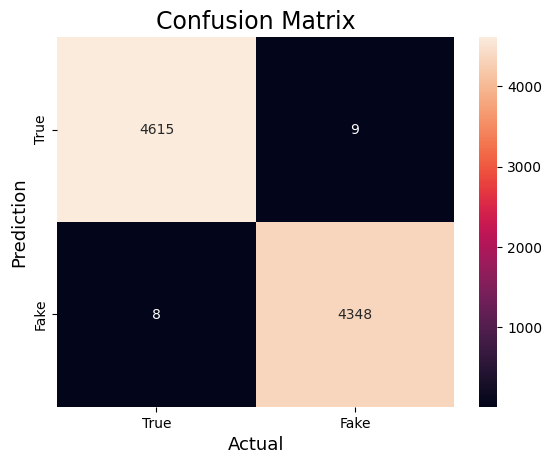

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def LogisticRegressionCountImplementation(train, test):
    start = dt.now()
    model = LogisticRegression(C=2.5)

    model.fit(X_vec_train, train.label)

    predicted_value = model.predict(X_vec_test)

    accuracy_value = roc_auc_score(test.label, predicted_value)
    print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
    print("f1 score -> " + str(f1_score(test.label,predicted_value)))
    running_secs = (dt.now() - start).seconds
    print('time: ' ,running_secs)
    cm = confusion_matrix(test.label,predicted_value)
    sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['True','Fake'],
            yticklabels=['True','Fake'])
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()

# def LogisticRegressionTfidfImplementation(train, test):
#     start = dt.now()

#     model = LogisticRegression(C=2.5)

#     model.fit(X_vec_train_tf, train.label)

#     predicted_value = model.predict(X_vec_test_tf)

#     accuracy_value = roc_auc_score(test.label, predicted_value)
#     print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
#     print("f1 score -> " + str(f1_score(test.label,predicted_value)))
#     running_secs = (dt.now() - start).seconds
#     print('time: ' ,running_secs)
#     pickle.dump(model,open('/content/drive/MyDrive/Colab Notebooks/model/lrtfidf','wb'))
# def LogisticRegressionWord2VecImplementation(train, test):
#     start = dt.now()

#     model = LogisticRegression(C=100,max_iter=4000)

#     model.fit(X_train, train.label)

#     predicted_value = model.predict(X_test)

#     accuracy_value = roc_auc_score(test.label, predicted_value)
#     print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
#     print("f1 score -> " + str(f1_score(test.label,predicted_value)))
#     running_secs = (dt.now() - start).seconds
#     print('time: ' ,running_secs)

print("Logistic Regression with BOW, Tf-Idf and Word2Vec accordingly")
LogisticRegressionCountImplementation(train, test)
# LogisticRegressionTfidfImplementation(train,test)
# LogisticRegressionWord2VecImplementation(train,test)
enable_warnings()

In [ ]:
stop_words = stopwords.words('english')
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)


    return result
def listToString(s):
    # initialize an empty string
    str1 = " "
    # return string
    return (str1.join(s))


In [ ]:
def NaiveBayesCountImplementation(train, test):
    start = dt.now()

    model = MultinomialNB(alpha=0.1)

    model.fit(X_vec_train, train.label)

    predicted_value = model.predict(X_vec_test)

    accuracy_value = roc_auc_score(test.label, predicted_value)
    print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
    print("f1 score -> " + str(f1_score(test.label,predicted_value)))
    running_secs = (dt.now() - start).seconds
    print('time: ' ,running_secs)
    print(predicted_value)

def NaiveBayesTfidfImplementation(train, test):
    start = dt.now()

    model = MultinomialNB(alpha=0.1)

    model.fit(X_vec_train_tf, train.label)

    predicted_value = model.predict(X_vec_test_tf)

    accuracy_value = roc_auc_score(test.label, predicted_value)
    print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
    print("f1 score -> " + str(f1_score(test.label,predicted_value)))
    running_secs = (dt.now() - start).seconds
    print('time: ' ,running_secs)

def NaiveBayesWord2VecImplementation(train, test):
    start = dt.now()
    model = MultinomialNB(alpha=0.1)

    # normalize values in X_train and X_test for the MultinomialNB
    # first we concatenate the two arrays into one...
    X_temp = np.concatenate((X_train, X_test))

    scaler = MinMaxScaler()
    # fit the scaler with the big array so that it finds the best minimum and maximum...
    scaler.fit(X_temp)
    # then transform the data
    X_temp = scaler.transform(X_temp)

    # then split the array again
    position = len(X_train)
    normalized_X_train, normalized_X_test = X_temp[:position, ...], X_temp[position:, ...]

    model.fit(normalized_X_train, train.label)

    predicted_value = model.predict(normalized_X_test)
    accuracy_value = roc_auc_score(test.label, predicted_value)
    print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
    print("f1 score -> " + str(f1_score(test.label,predicted_value)))
    running_secs = (dt.now() - start).seconds
    print('time: ' ,running_secs)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("Naive Bayes with BOW, Tf-Idf and Word2Vec accordingly")
NaiveBayesCountImplementation(train, test)
NaiveBayesTfidfImplementation(train, test)
NaiveBayesWord2VecImplementation(train,test)
enable_warnings()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Naive Bayes with BOW, Tf-Idf and Word2Vec accordingly
Accuracy -> 98.73%
f1 score -> 0.9868436105708728
time:  0
[0 0 1 ... 0 0 0]
Accuracy -> 98.27%
f1 score -> 0.9821632746398353
time:  0
Accuracy -> 88.47%
f1 score -> 0.87652678679405
time:  0


In [ ]:
def SVMCountImplementation(train, test):
    # SVM classifier
    start = dt.now()

    classifier = SVC(kernel = 'linear', random_state = 0)
    classifier.fit(X_vec_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_vec_test)

    accuracy_value = roc_auc_score(test.label, y_pred)

    print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
    print("f1 score -> " + str(f1_score(test.label,y_pred)))
    running_secs = (dt.now() - start).seconds
    print('time: ' ,running_secs)
    pickle.dump(classifier,open('/content/drive/MyDrive/Colab Notebooks/model/SVCbow','wb'))

def SVMTfidfImplementation(train, test):
    # SVM Classifier
    start = dt.now()

    classifier = SVC(kernel = 'linear', random_state = 0)
    classifier.fit(X_vec_train_tf, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_vec_test_tf)

    accuracy_value = roc_auc_score(test.label, y_pred)

    print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
    print("f1 score -> " + str(f1_score(test.label,y_pred)))
    running_secs = (dt.now() - start).seconds
    print('time: ' ,running_secs)
    pickle.dump(classifier,open('/content/drive/MyDrive/Colab Notebooks/model/SVCtfidf','wb'))

def SVMWord2VecImplementation(train, test):
    # SVM classifier
    start = dt.now()

    classifier = SVC(kernel = 'linear', random_state = 0)
    classifier.fit(X_train, train.label)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)

    accuracy_value = roc_auc_score(test.label, y_pred)

    print("Accuracy -> " + str(round(accuracy_value*100,2)) + "%")
    print("f1 score -> " + str(f1_score(test.label,y_pred)))
    running_secs = (dt.now() - start).seconds
    print('time: ' ,running_secs)
print("SVM with BOW, Tf-Idf and Word2Vec accordingly")
SVMCountImplementation(train,test)
SVMTfidfImplementation(train,test)
SVMWord2VecImplementation(train,test)
enable_warnings()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SVM with BOW, Tf-Idf and Word2Vec accordingly
Accuracy -> 99.81%
f1 score -> 0.9980493402180148
time:  634


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

Accuracy -> 99.52%
f1 score -> 0.9949656750572082
time:  2924


<ipython-input-17-277aae4bb1d7>:35: ResourceWarning: unclosed file <_io.BufferedWriter name='/content/drive/MyDrive/Colab Notebooks/model/SVCtfidf'>
  pickle.dump(classifier,open('/content/drive/MyDrive/Colab Notebooks/model/SVCtfidf','wb'))


Accuracy -> 96.72%
f1 score -> 0.9662895669066391
time:  41
